# Faster R-CNN for SoccerNet

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [3]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA GPU


### Load Images

**Note:** The annotations should also contain the corresponding image path

In [4]:
img_width = 1920
img_height = 1080
image_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")

#### Create Dataset and Dataloaders

In [6]:
from data_loader import SoccerDatasetSequence, get_dataloader


batch_size = 3 
num_images_to_display = 2

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=batch_size, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)

# Sample batch
img_data_all, gt_bboxes_all, gt_classes_all = next(iter(od_dataloader))
gt_classes_all

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1]])

### Display Images and Bounding Boxes

In [6]:
# get class names
ground_truth_dummy_classes = gt_classes_all[0].long()
ground_truth_dummy_classes = ["player" for idx in ground_truth_dummy_classes]

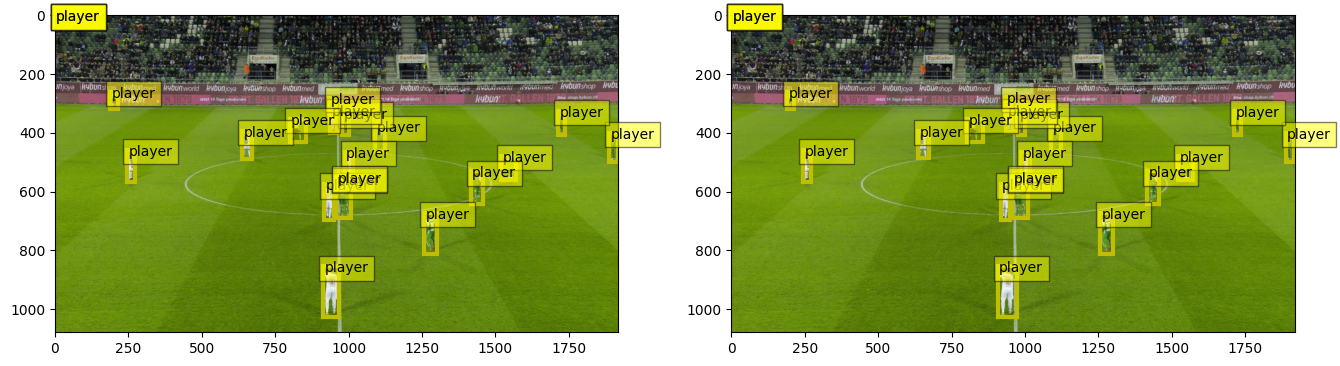

In [7]:

nrows, ncols = (1, num_images_to_display)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

for i in range(num_images_to_display):
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i], classes=ground_truth_dummy_classes)

## Inception v3 Feature Extractor

In [7]:
from featureExtractor import InceptionFeatureExtractor

backbone = InceptionFeatureExtractor()
out = backbone(img_data_all)
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
print('Out dims:', out_c, out_h, out_w)

width_scale_factor = img_width // out_w
height_scale_factor = img_height / out_h
print(img_width, img_height, '->', out_w, out_h)


height_scale_factor, width_scale_factor

Out dims: 2048 32 58
1920 1080 -> 58 32


(33.75, 33)

### Visualize 1st channel of feature map

(np.float64(-0.5), np.float64(57.5), np.float64(31.5), np.float64(-0.5))

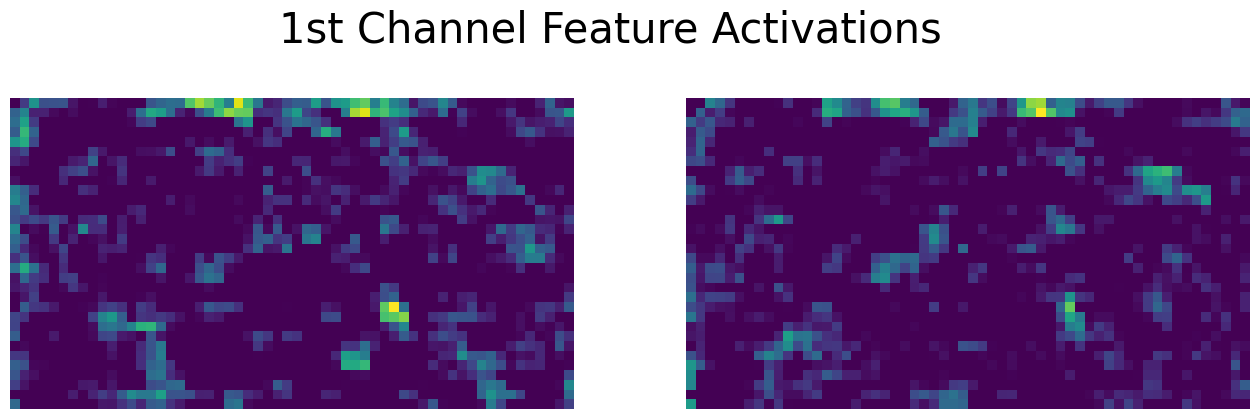

In [9]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, num_images_to_display, figsize=(16, 8))
fig.suptitle(f"1st Channel Feature Activations", fontsize=30, y=.80)
filters_data =[filters[0].detach().numpy() for filters in out[:2]]
fig, axes = display_img(filters_data, fig, axes)

axes[0].axis('off')
axes[1].axis('off')

### Visualize all channels of feature map

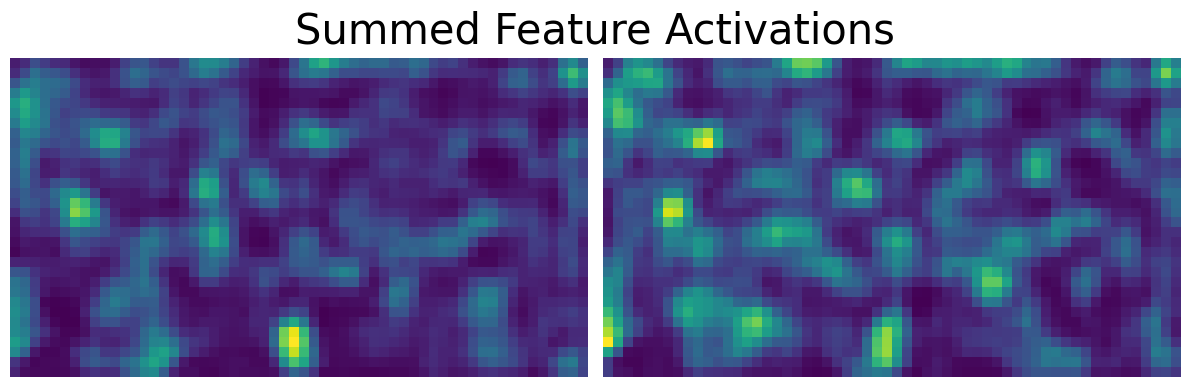

In [10]:
image_index_to_show = 0  # Choose which image from the batch to visualize

fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 6))
fig.suptitle(f"Summed Feature Activations", fontsize=30, y=.80)

for i in range(num_images_to_display):
    axes[i].axis('off')
    feature_map_single = out[i]
    activation_map_summed = feature_map_single.sum(dim=0)
    activation_map_np = activation_map_summed.detach().cpu().numpy()
    axes[i].imshow(activation_map_np, cmap='viridis')

plt.tight_layout()
plt.show()


### Generate and Plot Anchor Points, Sample Boxes

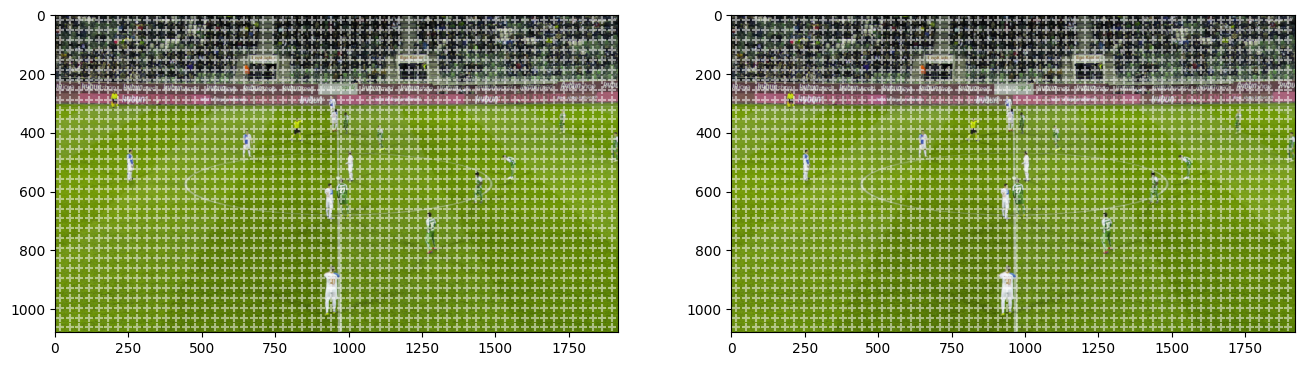

In [11]:
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w), device)

# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor


# Visualization
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
for i in range(num_images_to_display):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

# Create Anchor Boxes around Anchor points
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) 
anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w), device)
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

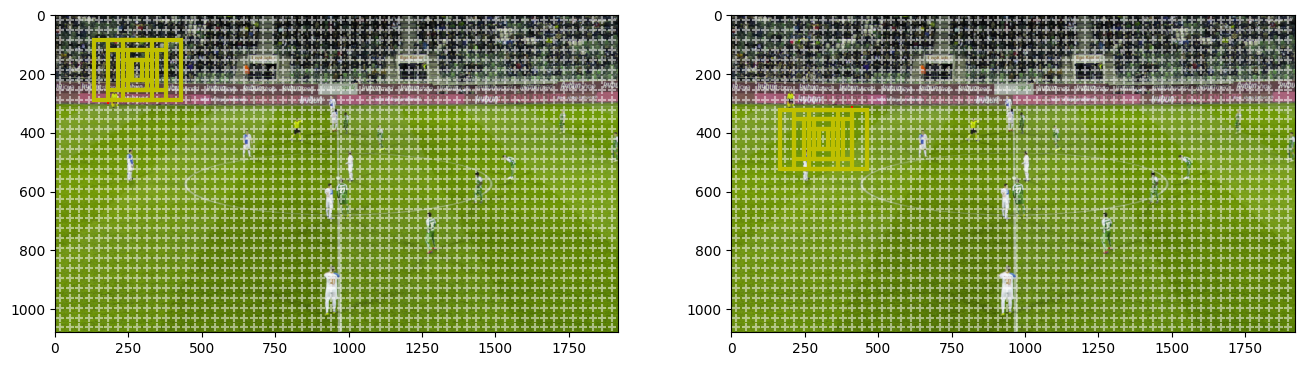

In [12]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# selected anchor points
sp = [[5, 8],[12, 9], [25,20]]

for i in range(num_images_to_display):
    sp_i = sp[i]
    bboxes_i = anc_boxes_proj[i][sp_i[0], sp_i[1]]
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i], (anc_pts_x_proj[sp_i[0]], anc_pts_y_proj[sp_i[1]]))
    fig, _ = display_bbox(bboxes_i, fig, axes[i])

### plot all anchor boxes

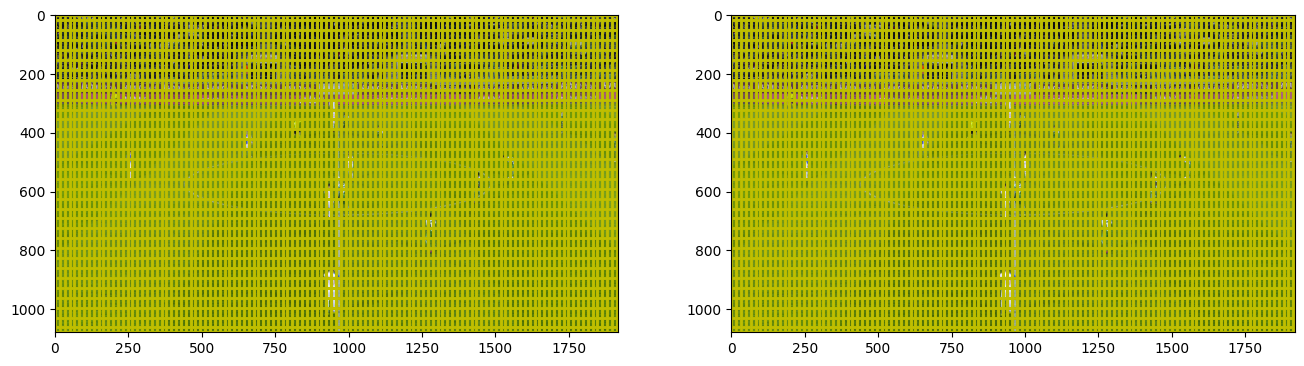

In [13]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
img_data_cpu = img_data_all[:num_images_to_display].cpu()
fig, axes = display_img(img_data_cpu, fig, axes)

anc_pts_x_proj_cpu = anc_pts_x_proj.cpu()
anc_pts_y_proj_cpu = anc_pts_y_proj.cpu()
anc_boxes_proj_cpu = anc_boxes_proj.cpu()

for x in range(anc_pts_x_proj_cpu.size(dim=0)):
    for y in range(anc_pts_y_proj_cpu.size(dim=0)):
       
        bboxes = anc_boxes_proj_cpu[0][y, x]
        for i in range(num_images_to_display):
            display_bbox(bboxes, fig, axes[i], line_width=1)

plt.show()

### Get Positive and Negative Anchors

In [14]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, device, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

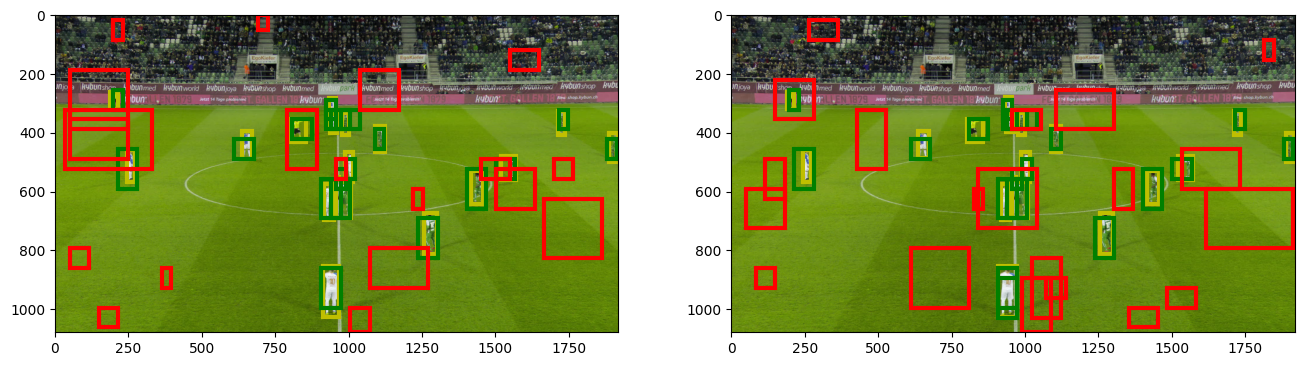

In [15]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately
fig, axes = plt.subplots(nrows, num_images_to_display, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

anc_idx = [] 
pos_anc = []
neg_anc = []
for i in range(num_images_to_display):
    anc_idx.append(torch.where(positive_anc_ind_sep == i)[0])
    pos_anc.append(pos_anc_proj[anc_idx[i]])
    neg_anc.append(neg_anc_proj[anc_idx[i]])

    #display ground truth bboxes
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i])
    #display positive anchor boxes
    fig, _ = display_bbox(pos_anc[i], fig, axes[i], color='g')
    #display negative anchor boxes
    fig, _ = display_bbox(neg_anc[i], fig, axes[i], color='r')

### Building the model

In [90]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
out_channels = out_c
roi_size = (2, 2)
n_classes = 2
# (img_size, out_channels, n_classes, roi_size)
detector = TwoStageDetector(img_size, out_channels, n_classes, roi_size)

/home/das.ag/.conda/envs/cs6140_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/das.ag/.conda/envs/cs6140_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [91]:

detector.to(device)
detector.eval() 

# Move data to the selected device
img_data_all_dev = img_data_all.to(device)
gt_bboxes_all_dev = gt_bboxes_all.to(device)
gt_classes_all_dev = gt_classes_all.long().to(device) # Ensure long type and device

with torch.no_grad(): # Use no_grad for evaluation/inference
    total_loss = detector(img_data_all_dev, gt_bboxes_all_dev, gt_classes_all_dev, device=device)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all_dev, device=device)

print(f"Total Loss (Evaluation): {total_loss.item()}")


Total Loss (Evaluation): 30.440868377685547


### Training loop

In [92]:
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.amp import GradScaler, autocast # For mixed precision

def training_loop(model, learning_rate, train_dataloader, n_epochs, device):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler(device=device.type) 

    model.to(device) # Move model to the selected device
    model.train()
    loss_list = []

    for i in range(n_epochs):
        print(f"Epoch {i+1}/{n_epochs}")
        total_loss = 0
        loop = tqdm(train_dataloader, leave=True)
        for img_batch, gt_bboxes_batch, gt_classes_batch in loop:

            # Move data to device
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            # ***** Ensure gt_classes are LongTensor and moved to device *****
            # Assuming gt_classes_batch is a tensor from the dataloader
            gt_classes_batch = gt_classes_batch.long().to(device)


            optimizer.zero_grad(set_to_none=True) # Use set_to_none=True for potential minor performance gain

            with autocast(device_type=device.type):
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch, device=device)

            if torch.isnan(loss):
                print("Warning: NaN loss detected. Skipping batch.")
                optimizer.zero_grad(set_to_none=True)
                continue

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            total_loss += batch_loss

            # Update tqdm progress bar description
            loop.set_description(f"Epoch {i+1}")
            loop.set_postfix(loss=batch_loss)

        avg_epoch_loss = total_loss / len(train_dataloader)
        loss_list.append(avg_epoch_loss)
        print(f"Epoch {i+1} Average Loss: {avg_epoch_loss:.4f}")

    return loss_list

# --- Running the training --- (Ensure detector and od_dataloader are defined)
# learning_rate = 1e-3
# n_epochs = 1
# loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)



# Move results back to CPU if needed for plotting or further processing
# proposals_final = [p.cpu() for p in proposals_final]
# conf_scores_final = [cs.cpu() for cs in conf_scores_final]
# classes_final = [c.cpu() for c in classes_final] # If classes are tensors

In [93]:
batch_size = 32

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=batch_size, 
    shuffle=True # Keep shuffle=False if you want the *first* sequence elements
)

learning_rate = 1e-2 # You might need to adjust this, especially with AMP
n_epochs = 5 
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)

detector.eval()
img_data_all = img_data_all.to(device)
with torch.no_grad():
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device=device)

loss_list

Epoch 1/5


  0%|          | 0/24 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.98 GiB. GPU 0 has a total capacity of 79.33 GiB of which 760.44 MiB is free. Including non-PyTorch memory, this process has 78.57 GiB memory in use. Of the allocated memory 74.54 GiB is allocated by PyTorch, and 3.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [76]:
loss_list

[42.392005920410156,
 42.36112753550211,
 42.25615199406942,
 42.242646058400474,
 42.17719014485677]

#### save model

In [77]:
from datetime import datetime
date_time = datetime.now().strftime("%m_%d_%Y-%H:%M:%S")
torch.save(detector.state_dict(), f"checkpoints/checkpoint_model_{date_time}.pt")

### Inference

In [87]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device, conf_thresh=0.71, nms_thresh=0.001)
proposals_final

[tensor([[ 4.9774e+00,  1.2455e+01,  7.9330e+00,  1.8366e+01],
         [ 7.9925e+00,  1.4485e+01,  8.9777e+00,  1.6455e+01],
         [ 8.9925e+00,  1.4485e+01,  9.9777e+00,  1.6455e+01],
         [ 9.9925e+00,  1.4485e+01,  1.0978e+01,  1.6455e+01],
         [ 1.0992e+01,  1.4485e+01,  1.1978e+01,  1.6455e+01],
         [ 1.1992e+01,  1.4485e+01,  1.2978e+01,  1.6455e+01],
         [ 1.2992e+01,  1.4485e+01,  1.3978e+01,  1.6455e+01],
         [ 1.3992e+01,  1.4485e+01,  1.4978e+01,  1.6455e+01],
         [ 1.4992e+01,  1.4485e+01,  1.5978e+01,  1.6455e+01],
         [ 1.5992e+01,  1.4485e+01,  1.6978e+01,  1.6455e+01],
         [ 1.6992e+01,  1.4485e+01,  1.7978e+01,  1.6455e+01],
         [ 1.7992e+01,  1.4485e+01,  1.8978e+01,  1.6455e+01],
         [ 1.8992e+01,  1.4485e+01,  1.9978e+01,  1.6455e+01],
         [ 1.9992e+01,  1.4485e+01,  2.0978e+01,  1.6455e+01],
         [ 2.0992e+01,  1.4485e+01,  2.1978e+01,  1.6455e+01],
         [ 2.1992e+01,  1.4485e+01,  2.2978e+01,  1.645

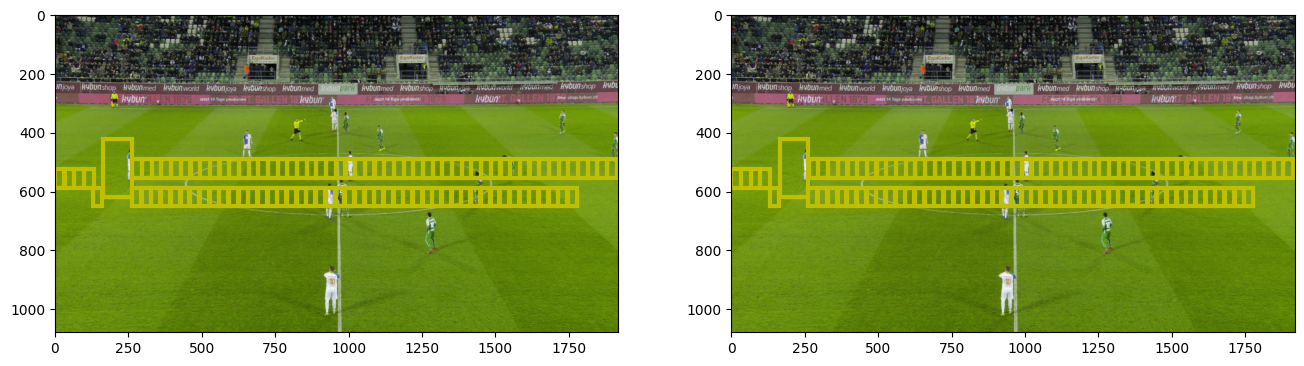

In [88]:
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
classes_pred_2 = ["player" for cls in classes_final[1].tolist()]

nimages = len(img_data_all)
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], )
fig, _ = display_bbox(prop_proj_2, fig, axes[1], )
plt.show()